In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [2]:
# Ruta al archivo CSV
file_path = "../data/csv/fomc_sentiment_full.csv"

# Leer CSV 
df = pd.read_csv(file_path, quotechar='"')


In [3]:

# Mostrar las primeras filas
df.head()


,Date,Release Date,Type,Text,Sentiment_Score,Sentiment_Label
0,2025-05-07,2025-05-28,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,positive
1,2025-05-07,2025-05-07,Statement,Although swings in net exports have affected t...,0.6249,positive
2,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...,0.9306,positive
3,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...,0.9998,positive
4,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...,0.7717,positive


In [4]:
import yfinance as yf
import pandas as pd

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
tickers = ['SAN.MC', 'BBVA.MC']
period = 'max'
interval = '1d'

# -----------------------------
# DESCARGAR DATOS
# -----------------------------
# auto_adjust=False para que Close sea el precio real
data = yf.download(tickers, period=period, interval=interval, auto_adjust=False)

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------
def add_features(df):
    # Rango diario
    df['range'] = df['high'] - df['low']
    
    # Retornos diarios
    df['return'] = df['close'].pct_change()
    
    # SMA 5 y 10 días
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    
    # Volumen relativo (comparado con media de 10 días)
    df['vol_rel'] = df['volume'] / df['volume'].rolling(window=10).mean()
    
    # Solo eliminar filas donde Close sea NaN (no por rolling)
    df = df[df['close'].notna()]
    
    return df

# -----------------------------
# PROCESAR Y GUARDAR POR TICKER
# -----------------------------
for ticker in tickers:
    # Seleccionar columnas de cada ticker usando xs
    df = data.xs(ticker, level=1, axis=1).copy()
    
    # Renombrar columnas a minúsculas
    df.columns = [col.lower() for col in df.columns]
    
    # Añadir features adicionales
    df = add_features(df)
    
    # Guardar CSV
    df.to_csv(f'{ticker.replace(".MC","")}_features.csv')
    print(f'CSV generado: {ticker.replace(".MC","")}_features.csv')


[*********************100%***********************]  2 of 2 completed


CSV generado: SAN_features.csv
CSV generado: BBVA_features.csv


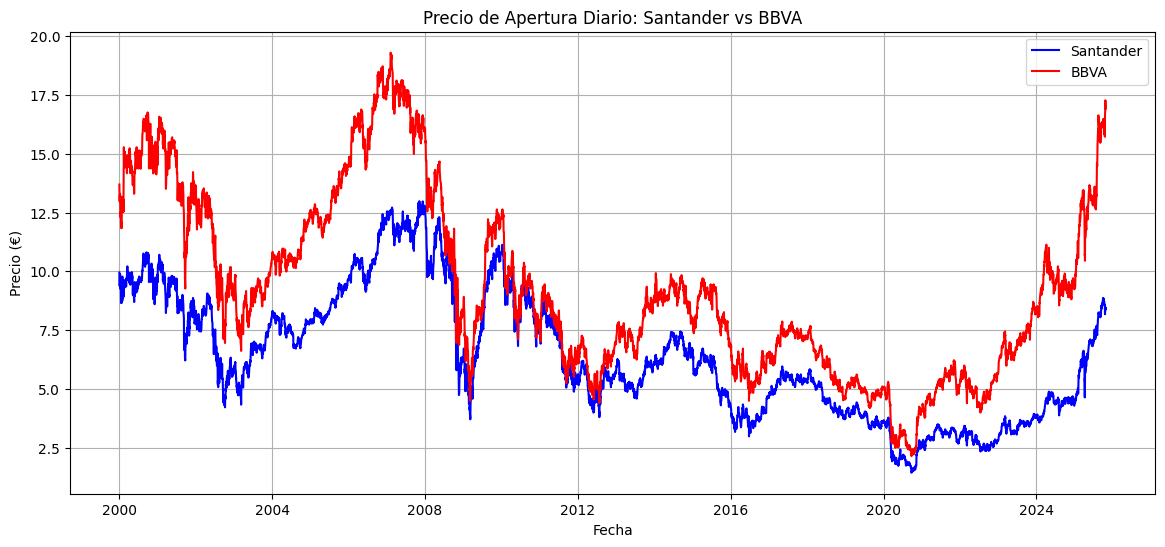

In [5]:
# Cargar CSV
df_san = pd.read_csv('..\data\csv\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\data\csv\BBVA_features.csv', index_col=0, parse_dates=True)

# Graficar precio de apertura
plt.figure(figsize=(14,6))
plt.plot(df_san.index, df_san['open'], label='Santander', color='blue')
plt.plot(df_bbva.index, df_bbva['open'], label='BBVA', color='red')

plt.title('Precio de Apertura Diario: Santander vs BBVA')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# ====================================================
# --- 1. Cargar dataset de sentimiento ---
# ====================================================
df_sent = pd.read_csv('../data/csv/fomc_sentiment_clean.csv')

# Normalizar nombres de columnas a minúsculas
df_sent.columns = [c.lower() for c in df_sent.columns]

# Detectar automáticamente la columna de fecha
fecha_cols = [c for c in df_sent.columns if "date" in c]
if not fecha_cols:
    raise ValueError("No se encontró ninguna columna de fecha en el CSV de sentimiento.")
fecha_col = fecha_cols[0]

# Convertir la fecha a datetime
df_sent[fecha_col] = pd.to_datetime(df_sent[fecha_col], errors='coerce')

# Renombrar para mantener consistencia
df_sent = df_sent.rename(columns={fecha_col: 'release_date'})

print("✅ Columna de fecha detectada:", fecha_col)
print(df_sent.head())

# ====================================================
# --- 2. Cargar datasets de precios ---
# ====================================================
df_san = pd.read_csv('../data/csv/SAN_features.csv', parse_dates=True, index_col=0)
df_bbva = pd.read_csv('../data/csv/BBVA_features.csv', parse_dates=True, index_col=0)

df_san.index = pd.to_datetime(df_san.index)
df_bbva.index = pd.to_datetime(df_bbva.index)

# ====================================================
# --- 3. Fusionar sentimiento (por fecha más cercana) ---
# ====================================================
df_san = df_san.merge(df_sent, how='left', left_index=True, right_on='release_date')
df_bbva = df_bbva.merge(df_sent, how='left', left_index=True, right_on='release_date')

# Rellenar los NaN con el último sentimiento conocido
df_san['sentiment_score'] = df_san['sentiment_score'].fillna(method='ffill').fillna(0)
df_bbva['sentiment_score'] = df_bbva['sentiment_score'].fillna(method='ffill').fillna(0)

# Eliminar columna duplicada de fecha
df_san = df_san.drop(columns=['release_date'])
df_bbva = df_bbva.drop(columns=['release_date'])

# Justo antes del escalado
df_san = df_san.replace([np.inf, -np.inf], np.nan).dropna()
df_bbva = df_bbva.replace([np.inf, -np.inf], np.nan).dropna()


print("\n✅ Fusionado correctamente.")
print("SAN columnas:", df_san.columns)
print("BBVA columnas:", df_bbva.columns)

# ====================================================
# --- 4. Escalado conjunto ---
# ====================================================
scaler_san = MinMaxScaler()
features_san_scaled = scaler_san.fit_transform(df_san.values)

scaler_bbva = MinMaxScaler()
features_bbva_scaled = scaler_bbva.fit_transform(df_bbva.values)

print("\nSAN shape:", features_san_scaled.shape)
print("BBVA shape:", features_bbva_scaled.shape)


✅ Columna de fecha detectada: date
  release_date  sentiment_score
0   2000-02-02          0.92775
1   2000-03-21          0.88910
2   2000-05-16          0.94420
3   2000-06-28          0.51280
4   2000-08-22          0.70090

✅ Fusionado correctamente.
SAN columnas: Index(['adj close', 'close', 'high', 'low', 'open', 'volume', 'range',
       'return', 'sma_5', 'sma_10', 'vol_rel', 'sentiment_score'],
      dtype='object')
BBVA columnas: Index(['adj close', 'close', 'high', 'low', 'open', 'volume', 'range',
       'return', 'sma_5', 'sma_10', 'vol_rel', 'sentiment_score'],
      dtype='object')

SAN shape: (6621, 12)
BBVA shape: (6621, 12)


C:\Users\josit\AppData\Local\Temp\ipykernel_16368\1270132939.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_san['sentiment_score'] = df_san['sentiment_score'].fillna(method='ffill').fillna(0)
C:\Users\josit\AppData\Local\Temp\ipykernel_16368\1270132939.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bbva['sentiment_score'] = df_bbva['sentiment_score'].fillna(method='ffill').fillna(0)


In [7]:
# ============================================================
# --- 1. Librerías ---
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ============================================================
# --- 2. Función para crear dataset con ventanas ---
# ============================================================
def create_windowed_dataset(features, target_col_index=-3, window_size=5):
    """
    Crea un dataset con ventanas temporales de tamaño 'window_size'.
    - features: array de características escaladas (n_días x n_features)
    - target_col_index: índice de la columna que se quiere predecir (por defecto la penúltima, suele ser 'Close')
    - window_size: nº de días en la ventana
    """
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(features[i+window_size][target_col_index])
    return np.array(X), np.array(y).reshape(-1,1)

# ============================================================
# --- 3. Crear datasets para SAN y BBVA ---
# ============================================================
window_size = 5

X_san, y_san = create_windowed_dataset(features_san_scaled, window_size=window_size)
X_bbva, y_bbva = create_windowed_dataset(features_bbva_scaled, window_size=window_size)

print(f"SAN -> X: {X_san.shape}, y: {y_san.shape}")
print(f"BBVA -> X: {X_bbva.shape}, y: {y_bbva.shape}")

# ============================================================
# --- 4. Convertir a tensores y pasar a GPU ---
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

X_san_t = torch.tensor(X_san, dtype=torch.float32).to(device)
y_san_t = torch.tensor(y_san, dtype=torch.float32).to(device)

X_bbva_t = torch.tensor(X_bbva, dtype=torch.float32).to(device)
y_bbva_t = torch.tensor(y_bbva, dtype=torch.float32).to(device)

# ============================================================
# --- 5. DataLoaders ---
# ============================================================
batch_size = 64
san_loader = DataLoader(TensorDataset(X_san_t, y_san_t), batch_size=batch_size, shuffle=True)
bbva_loader = DataLoader(TensorDataset(X_bbva_t, y_bbva_t), batch_size=batch_size, shuffle=True)

# ============================================================
# --- 6. Definir modelo LSTM ---
# ============================================================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # salida del último timestep

# Dimensión de entrada = nº de features (incluye Sentiment)
input_dim = X_san_t.shape[2]

model_san = LSTMModel(input_dim).to(device)
model_bbva = LSTMModel(input_dim).to(device)

# ============================================================
# --- 7. Configuración del entrenamiento ---
# ============================================================
criterion = nn.MSELoss()
optimizer_san = optim.Adam(model_san.parameters(), lr=0.001)
optimizer_bbva = optim.Adam(model_bbva.parameters(), lr=0.001)

num_epochs = 600  # puedes subirlo si quieres (ej. 500)
print("\n🚀 Entrenando modelos...\n")

# ============================================================
# --- 8. Entrenamiento ---
# ============================================================
for epoch in range(1, num_epochs+1):
    model_san.train()
    model_bbva.train()

    epoch_loss_san, epoch_loss_bbva = 0, 0

    # --- Santander ---
    for xb, yb in san_loader:
        optimizer_san.zero_grad()
        output = model_san(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_san.step()
        epoch_loss_san += loss.item() * xb.size(0)
    epoch_loss_san /= len(san_loader.dataset)
    
    # --- BBVA ---
    for xb, yb in bbva_loader:
        optimizer_bbva.zero_grad()
        output = model_bbva(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_bbva.step()
        epoch_loss_bbva += loss.item() * xb.size(0)
    epoch_loss_bbva /= len(bbva_loader.dataset)

    # --- Progreso ---
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} | "
              f"Loss SAN: {epoch_loss_san:.6f} | "
              f"Loss BBVA: {epoch_loss_bbva:.6f}")


SAN -> X: (6616, 5, 12), y: (6616, 1)
BBVA -> X: (6616, 5, 12), y: (6616, 1)
Usando dispositivo: cuda

🚀 Entrenando modelos...

Epoch 10/600 | Loss SAN: 0.000150 | Loss BBVA: 0.000162
Epoch 20/600 | Loss SAN: 0.000102 | Loss BBVA: 0.000090
Epoch 30/600 | Loss SAN: 0.000101 | Loss BBVA: 0.000081
Epoch 40/600 | Loss SAN: 0.000064 | Loss BBVA: 0.000065
Epoch 50/600 | Loss SAN: 0.000072 | Loss BBVA: 0.000065
Epoch 60/600 | Loss SAN: 0.000068 | Loss BBVA: 0.000060
Epoch 70/600 | Loss SAN: 0.000045 | Loss BBVA: 0.000054
Epoch 80/600 | Loss SAN: 0.000044 | Loss BBVA: 0.000046
Epoch 90/600 | Loss SAN: 0.000044 | Loss BBVA: 0.000039
Epoch 100/600 | Loss SAN: 0.000043 | Loss BBVA: 0.000039
Epoch 110/600 | Loss SAN: 0.000035 | Loss BBVA: 0.000043
Epoch 120/600 | Loss SAN: 0.000037 | Loss BBVA: 0.000031
Epoch 130/600 | Loss SAN: 0.000037 | Loss BBVA: 0.000039
Epoch 140/600 | Loss SAN: 0.000034 | Loss BBVA: 0.000046
Epoch 150/600 | Loss SAN: 0.000030 | Loss BBVA: 0.000036
Epoch 160/600 | Loss SAN: 

In [8]:

# ============================================================
# --- 9. Guardar modelos entrenados ---
# ============================================================
torch.save(model_san.state_dict(), "../models/lstm_santander.pth")
torch.save(model_bbva.state_dict(), "../models/lstm_bbva.pth")
print("\n✅ Modelos entrenados y guardados correctamente.")



✅ Modelos entrenados y guardados correctamente.


💾 Guardados:
 - ../data/csv/pred_bbva_5dias.csv
 - ../data/csv/pred_san_5dias.csv


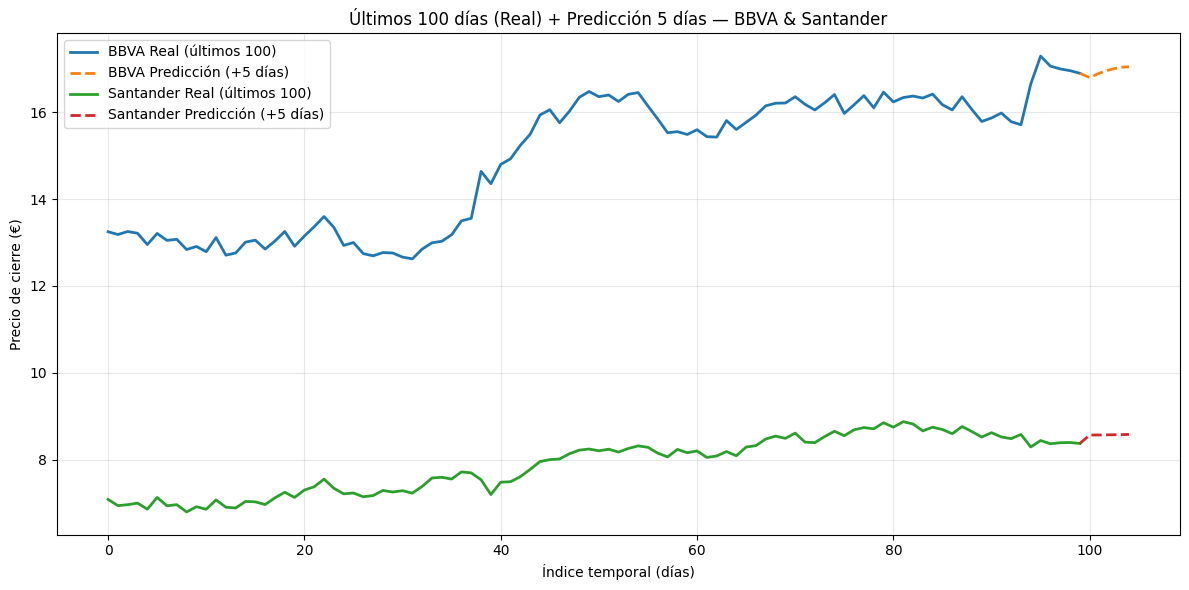

In [ ]:
# ============================================================
# PREDICCIÓN +5, DESNORMALIZACIÓN Y GRÁFICA
# ============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import BDay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 0) Utilidades ---
def find_close_index(df_cols):
    """Devuelve el índice (int) de la columna 'Close' (case-insensitive)."""
    cols_lower = [c.lower() for c in df_cols]
    if "close" not in cols_lower:
        raise ValueError("No encuentro la columna 'Close' en el DataFrame.")
    return cols_lower.index("close")

def inverse_close_from_scaled(pred_scaled_1d, scaler, n_features, close_idx):
    """
    pred_scaled_1d: array shape (n_pred,) con valores ESCALADOS de la columna 'Close'
    Devuelve vector desescalado de Close (n_pred,)
    """
    # Construimos matriz n_pred x n_features con ceros y metemos el Close en su columna
    tmp = np.zeros((len(pred_scaled_1d), n_features), dtype=float)
    tmp[:, close_idx] = pred_scaled_1d
    inv = scaler.inverse_transform(tmp)
    return inv[:, close_idx]

def predict_future(model, features_scaled, window_size, close_idx):
    """
    Predicción autorregresiva: usa la última ventana (scaled) y va
    alimentando la ventana con el Close predicho.
    Devuelve: array (5,) con CLOSE en ESCALA ESCALADA (0-1)
    """
    model.eval()
    with torch.no_grad():
        # Tomamos la última ventana
        last_window = torch.tensor(
            features_scaled[-window_size:], dtype=torch.float32, device=device
        ).unsqueeze(0)   # shape: (1, window, features)

        preds = []
        for _ in range(5):
            out = model(last_window)              # -> (1,1)
            pred_close_scaled = out.squeeze(0).squeeze(0).item()
            preds.append(pred_close_scaled)

            # Construimos nueva fila (copiamos la última observación y sustituimos close)
            new_row = last_window[:, -1, :].clone()
            new_row[:, close_idx] = pred_close_scaled

            # Desplazamos ventana: quitamos la primera fila y añadimos la nueva al final
            last_window = torch.cat([last_window[:, 1:, :], new_row.unsqueeze(1)], dim=1)

    return np.array(preds, dtype=float)

# --- 1) Preparar índices de Close y tamaños ---
close_idx_bbva = find_close_index(df_bbva.columns)
close_idx_san  = find_close_index(df_san.columns)

n_features_bbva = df_bbva.shape[1]
n_features_san  = df_san.shape[1]

# Si no tienes a mano el window_size, lo inferimos del modelo: usamos el que usaste en training.
try:
    window_size = X_bbva_t.shape[1]  # si existe X_bbva_t
except:
    window_size = 5  # por defecto

# --- 2) Predicción +5 en ESCALA ESCALADA ---
pred_bbva_scaled = predict_future(model_bbva, features_bbva_scaled, window_size, close_idx_bbva)
pred_san_scaled  = predict_future(model_san,  features_san_scaled,  window_size, close_idx_san)

# --- 3) Desnormalizar predicciones a euros ---
pred_bbva_close = inverse_close_from_scaled(pred_bbva_scaled, scaler_bbva, n_features_bbva, close_idx_bbva)
pred_san_close  = inverse_close_from_scaled(pred_san_scaled,  scaler_san,  n_features_san,  close_idx_san)

# --- 4) Serie real (últimos 100 días) en euros directamente del DF original ---
real_bbva_close = df_bbva.iloc[-100:, close_idx_bbva].to_numpy(dtype=float)
real_san_close  = df_san.iloc[-100:,  close_idx_san].to_numpy(dtype=float)

# --- 5) Fechas futuras hábiles + guardado CSV (opcional) ---
df_bbva.index = pd.to_datetime(df_bbva.index, errors='coerce')
df_san.index  = pd.to_datetime(df_san.index,  errors='coerce')
df_bbva = df_bbva[~df_bbva.index.isna()]
df_san  = df_san[~df_san.index.isna()]

last_date_bbva = df_bbva.index.max()
last_date_san  = df_san.index.max()

future_dates_bbva = pd.bdate_range(start=last_date_bbva + BDay(1), periods=5)
future_dates_san  = pd.bdate_range(start=last_date_san  + BDay(1), periods=5)

df_pred_bbva = pd.DataFrame({"Fecha": future_dates_bbva, "Prediccion_Close_BBVA": np.round(pred_bbva_close, 4)})
df_pred_san  = pd.DataFrame({"Fecha": future_dates_san,  "Prediccion_Close_SAN":  np.round(pred_san_close, 4)})


# --- 6) Gráfica: Real (últimos 100) + Predicción (5) pegada y continua (BBVA y SAN en la misma figura) ---
plt.figure(figsize=(12, 6))

# Ejes para BBVA
x_real_bbva = np.arange(len(real_bbva_close))
x_pred_bbva = np.arange(len(real_bbva_close) - 1, len(real_bbva_close) - 1 + len(pred_bbva_close) + 1)

# Dibujar BBVA
plt.plot(x_real_bbva, real_bbva_close, label="BBVA Real (últimos 100)", linewidth=2)
plt.plot(x_pred_bbva,
         np.concatenate([[real_bbva_close[-1]], pred_bbva_close]),
         linestyle="--", label="BBVA Predicción (+5 días)", linewidth=2)

# Ejes para SAN
x_real_san = np.arange(len(real_san_close))
x_pred_san = np.arange(len(real_san_close) - 1, len(real_san_close) - 1 + len(pred_san_close) + 1)

# Dibujar SAN
plt.plot(x_real_san, real_san_close, label="Santander Real (últimos 100)", linewidth=2)
plt.plot(x_pred_san,
         np.concatenate([[real_san_close[-1]], pred_san_close]),
         linestyle="--", label="Santander Predicción (+5 días)", linewidth=2)

plt.title("Últimos 100 días (Real) + Predicción 5 días — BBVA & Santander")
plt.xlabel("Índice temporal (días)")
plt.ylabel("Precio de cierre (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
